# Training Notebook

In [2]:
from kyber_py import *

import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import sympy as sp
from sympy import ntheory

import math
import matplotlib.pyplot as plt


## Dataset creation

### Fourier Complex Numbers

In [3]:
def fourier_int_to_complex(x, q):
    """
    Maps integer tensor x (mod q) to a complex number using the Fourier transform.
    Uses the mapping: x -> exp(2*pi*i * x / q)
    """
    return torch.exp(2j * math.pi * x / q)

def fourier_complex_to_int(x, q):
    """
    Maps complex tensor x to an integer tensor (mod q) using the Fourier transform.
    Uses the mapping: x -> log(x) * q / (2*pi)
    """
    return torch.imag(torch.log(x) * q / (2 * math.pi))

def multiplicative_int_to_complex(x, q):
    """
    Maps an integer x (mod q) to a complex number.
    For x != 0, find k such that x = g^k mod q, then map to exp(2pi i k/(q-1)).
    Define f(0) = 0.
    """
    g = ntheory.primitive_root(q)
    k = torch.tensor([ntheory.discrete_log(q, item.long(), g) if item != 0 else 0 for item in x.flatten()]).reshape(x.shape)
    return fourier_int_to_complex(k, q-1)

def multiplicative_complex_to_int(z, q):
    """
    Inverse mapping from a complex number on the unit circle to an integer (mod q).
    For z != 0, compute the angle theta, then find k = round((q-1)*theta/(2pi)) mod (q-1)
    and return g^k mod q.
    """
    # Get angle in [0, 2pi)
    g = ntheory.primitive_root(q)
    k = fourier_complex_to_int(z, q-1)
    k = k.round().long() % (q-1)
    return torch.tensor([pow(g, item.item(), q) for item in k.flatten()]).reshape(k.shape)

In [4]:
import time
import random

def test_fourier():
  num_runs = 5000
  total_complex_time = 0
  total_int_time = 0
  total_multiplicative_complex_time = 0
  total_multiplicative_int_time = 0
  correct = True

  primes = list(sp.primerange(0, 5000))

  for _ in range(num_runs):
    q = random.choice(primes)
    a = random.randint(0, q-1)

    try:
      start_time = time.time()
      complex_a = fourier_int_to_complex(torch.tensor([a]), q)
      total_complex_time += time.time() - start_time

      start_time = time.time()
      int_a = fourier_complex_to_int(complex_a, q)
      int_a = int_a.round() % q
      total_int_time += time.time() - start_time

      if int_a.item() != a:
        print(f"Error: {a} -> {complex_a} -> {int_a}")
        correct = False
    except:
      print(f"Error with a={a}, q={q}")
      correct = False

    q = random.choice(primes)
    a = random.randint(1, q-1) # Avoid 0 for multiplicative (it does not have a separate representation)

    try:
      start_time = time.time()
      complex_a = multiplicative_int_to_complex(torch.tensor([a]), q)
      total_multiplicative_complex_time += time.time() - start_time

      start_time = time.time()
      int_a = multiplicative_complex_to_int(complex_a, q)
      total_multiplicative_int_time += time.time() - start_time

      if int_a.item() != a:
        print(f"Error (multiplicative): {a} -> {complex_a} -> {int_a} (mod {q})")
        correct = False
    except:
      print(f"Error (multiplicative) with a={a}, q={q}")
      correct = False

  avg_complex_time = total_complex_time / num_runs
  avg_int_time = total_int_time / num_runs
  avg_multiplicative_complex_time = total_multiplicative_complex_time / num_runs
  avg_multiplicative_int_time = total_multiplicative_int_time / num_runs

  return avg_complex_time, avg_int_time, avg_multiplicative_complex_time, avg_multiplicative_int_time, correct

avg_complex_time, avg_int_time, avg_multiplicative_complex_time, avg_multiplicative_int_time, correct = test_fourier()
print(f"Average time to convert to complex: {avg_complex_time:.6f} seconds")
print(f"Average time to convert back to int: {avg_int_time:.6f} seconds")
print(f"Average time to convert to multiplicative complex: {avg_multiplicative_complex_time:.6f} seconds")
print(f"Average time to convert back to multiplicative int: {avg_multiplicative_int_time:.6f} seconds")
print(f"Correctness: {correct}")

Average time to convert to complex: 0.000166 seconds
Average time to convert back to int: 0.000218 seconds
Average time to convert to multiplicative complex: 0.000772 seconds
Average time to convert back to multiplicative int: 0.000478 seconds
Correctness: True


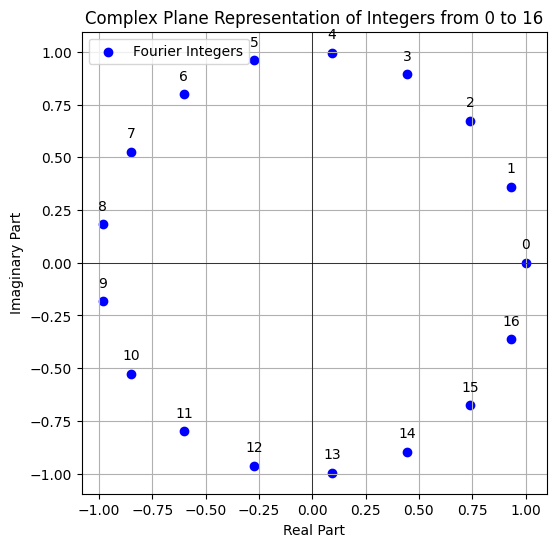

In [5]:
def plot_complex_with_elements(additional_elements=None, q=17, function=None, label='Fourier Integers'):
    # Generate integers from 0 to q-1
    integers = torch.arange(0, q)
    
    # Map integers to complex numbers using Fourier transform
    if function:
        complex_numbers = function(integers, q)
    else:
        complex_numbers = fourier_int_to_complex(integers, q)
    
    # Create the plot
    plt.figure(figsize=(6, 6))
    plt.scatter(complex_numbers.real, complex_numbers.imag, color='blue', label='Fourier Integers')
    
    # Annotate each point with its corresponding integer
    for i, (real, imag) in enumerate(zip(complex_numbers.real, complex_numbers.imag)):
        plt.annotate(str(integers[i].item()), (real.item(), imag.item()), 
                     textcoords="offset points", xytext=(0, 10), ha='center')
    
    # Plot additional complex elements if provided
    if additional_elements is not None:
        if type(additional_elements) == list:
            additional_elements = torch.tensor(additional_elements)

        additional_elements = additional_elements.to(torch.complex64)
        plt.scatter(additional_elements.real, additional_elements.imag, color='red', label=label)
        
        # Annotate additional elements
        for i, (real, imag) in enumerate(zip(additional_elements.real, additional_elements.imag)):
            plt.annotate(f'Z{i+1}', (real.item(), imag.item()), 
                         textcoords="offset points", xytext=(0, -15), ha='center', color='red')
    
    # Formatting the plot
    plt.xlabel('Real Part')
    plt.ylabel('Imaginary Part')
    plt.title(f'Complex Plane Representation of Integers from 0 to {q-1}')
    plt.axhline(0, color='black', linewidth=0.5)
    plt.axvline(0, color='black', linewidth=0.5)
    plt.grid(True)
    plt.legend()
    plt.show()

plot_complex_with_elements()

Complex representation of 2: tensor([0.7390+0.6737j])
Complex representation of 20: tensor([0.4457+0.8952j])

Addition of 2 + 20 mod 17: 5
Addition result: 5

Multiplication of 2 * 20 mod 17: 6
Multiplication result: 6


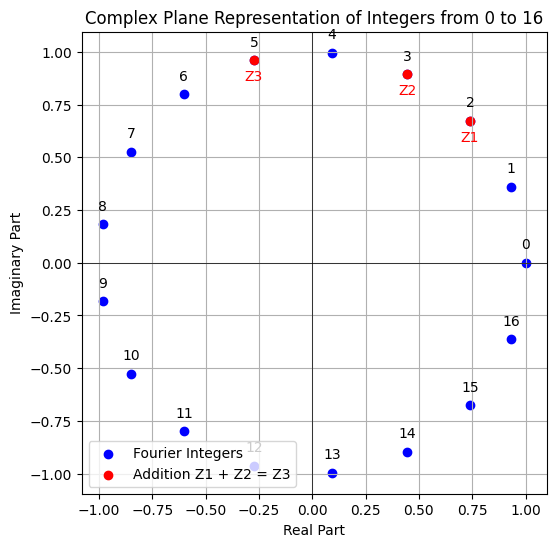

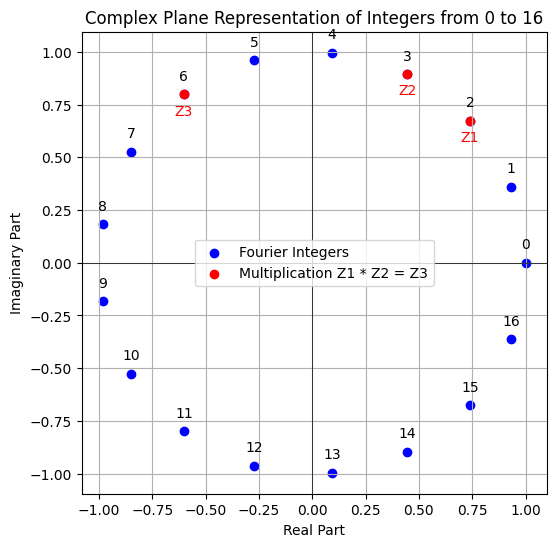

In [7]:
a = 2
b = 20
q = 17

# Map integers to complex numbers using Fourier transform
complex_a = fourier_int_to_complex(torch.tensor([a]), q)
complex_b = fourier_int_to_complex(torch.tensor([b]), q)
print(f'Complex representation of {a}: {complex_a}')
print(f'Complex representation of {b}: {complex_b}\n')

# Perform addition in the exponent space
complex_add = complex_a * complex_b

# Perform multiplication in the exponent space
complex_mul = complex_a ** b

# Map the result back to an integer
add_result = fourier_complex_to_int(complex_add, q)
add_result = add_result.round().long() % q

mul_result = fourier_complex_to_int(complex_mul, q)
mul_result = mul_result.round().long() % q

print(f"Addition of {a} + {b} mod {q}: {a+b % q}")
print(f'Addition result: {add_result.item()}\n')

print(f"Multiplication of {a} * {b} mod {q}: {a*b % q}")
print(f'Multiplication result: {mul_result.item()}')


plot_complex_with_elements(additional_elements=[complex_a, complex_b, complex_add], function=fourier_int_to_complex, label='Addition Z1 + Z2 = Z3')
plot_complex_with_elements(additional_elements=[complex_a, complex_b, complex_mul], function=fourier_int_to_complex, label='Multiplication Z1 * Z2 = Z3')

Transforming the descrete log of the number instead of the number could solve the problem with exponentiation, but it transforms both the 0 and 1 into 0, so we cannot recover the initial rappresentation from 0. So we cannot use it to map the values from finite field to complex field (sadly)

Complex representation of 4 * 6 mod 17: tensor([7])
Check: 4 * 6 mod 17 = 7


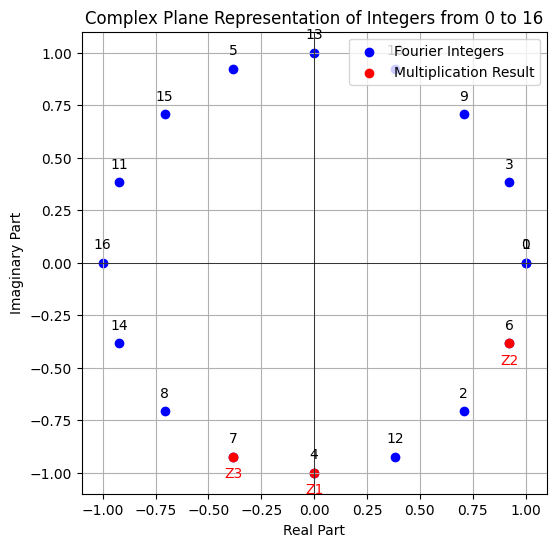

In [7]:
# Parameters
q = 17          # a prime modulus
a = 4
b = 6

# Plot the complex numbers
a_complex = multiplicative_int_to_complex(torch.tensor([a]), q)
b_complex = multiplicative_int_to_complex(torch.tensor([b]), q)

# Perform multiplication in the exponent space
result_complex = a_complex * b_complex

# Map the result back to an integer
result = multiplicative_complex_to_int(result_complex, q)
print(f'Complex representation of {a} * {b} mod {q}: {result}')
print("Check:", a, "*", b, "mod", q, "=", a * b % q)

# Plot the complex numbers
plot_complex_with_elements([a_complex, b_complex, result_complex], function=multiplicative_int_to_complex, q=q, label='Multiplication Result')

In [8]:
q = 3329

a = torch.randint(0, q, (2,2,8), dtype=torch.float64)
#a = torch.tensor([2267])
b = torch.randint(0, q, (2,2,8), dtype=torch.float64)
#b = torch.tensor([2629])

# Map integers to complex numbers using Fourier transform
a_complex = fourier_int_to_complex(a, q)

# exponentiate the complex numbers
exp_result = a_complex ** b
exp_result_int = fourier_complex_to_int(exp_result, q)
exp_result_int = exp_result_int.round().long() % q

# Find positions where exp_result_int and a * b % q differ
difference_positions = torch.nonzero(exp_result_int != (a * b) % q, as_tuple=True)
for pos in zip(*difference_positions):
  print(f"a: {a[pos]}, b: {b[pos]}")
  print(f"exp_result_int: {exp_result_int[pos]}, (a * b) % q: {(a * b)[pos] % q}")
print()

assert torch.all(exp_result_int == (a * b) % q)

# Reduce using multiplication
result = torch.prod(exp_result, dim=0)
result_int = fourier_complex_to_int(result, q)
result_int = result_int.round().long() % q

# Find positions where result_int and a + b % q differ
difference_positions = torch.nonzero(result_int != torch.sum(a * b, dim=0) % q, as_tuple=True)
for pos in zip(*difference_positions):
  print(f"a: {a[:, :, pos[1]]}, b: {b[:, :, pos[1]]}")
  print(f"result_int: {result_int[pos]}, (a + b) % q: {torch.sum(a * b, dim=0)[pos] % q}")

assert torch.all(result_int == torch.sum(a * b, dim=0) % q)

# Plot the complex numbers
#plot_complex_with_elements([a_complex[0], b_complex[0], exp_result[0]], function=fourier_int_to_complex, q=q, label='Exponentiation Result')

Combining fourier transform with fft:

FFT of tensor([4, 6, 8]): tensor([18.+0.0000j, -3.+1.7321j, -3.-1.7321j])


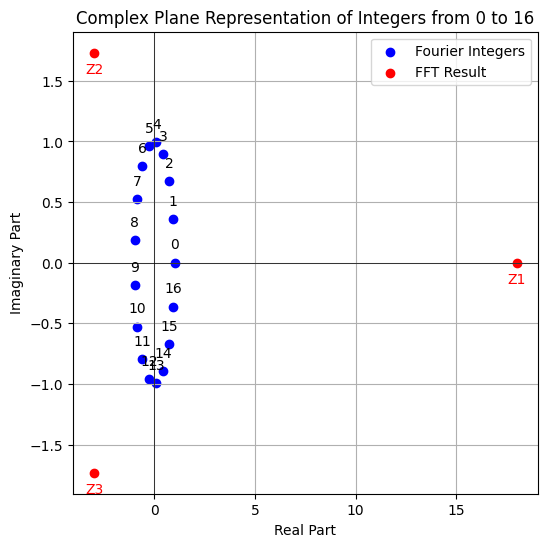

In [9]:
a = torch.tensor([4, 6, 8])

# Map integers to complex numbers using Fourier transform
#a_complex = fourier_int_to_complex(a, q)
a_fft = torch.fft.fft(a)

print(f'FFT of {a}: {a_fft}')

plot_complex_with_elements([a_fft[0], a_fft[1], a_fft[2]], label='FFT Result')

That is because addition is not allowed in the complex unit cicle:

Complex addition: tensor([4, 6, 8]) + tensor([ 6,  8, 10]) mod 17 = tensor([ 5.0000,  7.0000, -8.0000])
Check: tensor([4, 6, 8]) + tensor([ 6,  8, 10]) mod 17 = tensor([10, 14,  1])


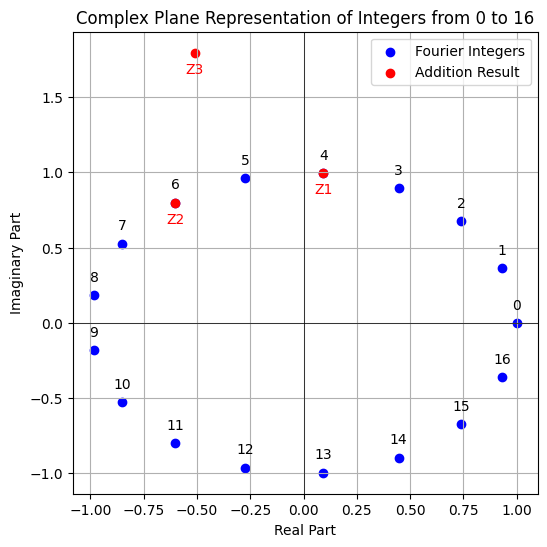

In [10]:
a = torch.tensor([4, 6, 8])
b = torch.tensor([6, 8, 10])
q = 17

# Map integers to complex numbers using Fourier transform
a_complex = fourier_int_to_complex(a, q)
b_complex = fourier_int_to_complex(b, q)

# Perform element-wise addition in the exponent space
result_complex = a_complex + b_complex

# Map the result back to an integer
result = fourier_complex_to_int(result_complex, q)
print(f'Complex addition: {a} + {b} mod {q} = {result}')
print("Check:", a, "+", b, "mod", q, "=", (a + b) % q)

# Plot the complex numbers
plot_complex_with_elements([a_complex[0], b_complex[0], result_complex[0]], function=fourier_int_to_complex, q=q, label='Addition Result')

Try to transform the NTT in the complex domain

In [11]:
def br(i: int, k: int) -> int:
    """
    bit reversal of an unsigned k-bit integer
    """
    bin_i = bin(i & (2**k - 1))[2:].zfill(k)
    return int(bin_i[::-1], 2)

def fourier_ntt(tensor: torch.Tensor, q: int, dim: int = -1) -> torch.Tensor:
    coeffs = tensor.clone()
    n = coeffs.shape[dim]
    
    root = find_root_of_unity(n, q)
    if root is None:
        raise ValueError(f"No primitive root of unity found for n={n} and q={q}")
    ntt_zetas = [pow(root, br(i, int(math.log2(n))-1), q) for i in range(n // 2)]

    k, l = 1, n // 2
    while l >= 2:
        start = 0
        while start < n:
            zeta = ntt_zetas[k]
            k += 1
            for j in range(start, start + l):
                t = coeffs.index_select(
                    dim, 
                    torch.tensor([j + l])
                )  # Zeta exponentiation
                t = t ** zeta
                
                coeffs.index_copy_(
                    dim,
                    torch.tensor([j + l]),
                    coeffs.index_select(dim, torch.tensor([j])) / t
                )  # Element-wise division

                coeffs.index_copy_(
                    dim,
                    torch.tensor([j]), 
                    coeffs.index_select(dim, torch.tensor([j])) * t
                )  # Element-wise multiplication

            start = l + j + 1
        l >>= 1
        
    return coeffs

def fourier_intt(tensor: torch.Tensor, q: int, dim: int = -1) -> torch.Tensor:
    coeffs = tensor.clone()
    n = coeffs.shape[dim]

    root = find_root_of_unity(n, q)
    ntt_zetas = [pow(root, br(i, int(math.log2(n))-1), q) for i in range(n // 2)]
    ntt_f = pow(n // 2, -1, q)

    l, l_upper = 2, n // 2
    k = l_upper - 1
    while l <= l_upper:
        start = 0
        while start < n:
            zeta = ntt_zetas[k]
            k -= 1
            for j in range(start, start + l):
                t = coeffs.index_select(dim, torch.tensor([j]))  # Ensure correct shape
                
                coeffs.index_copy_(
                    dim,
                    torch.tensor([j]),
                    coeffs.index_select(dim, torch.tensor([j + l])) * t
                )  # Element-wise multiplication

                coeffs.index_copy_(
                    dim,
                    torch.tensor([j + l]),
                    coeffs.index_select(dim, torch.tensor([j + l])) / t
                )  # Element-wise division

                coeffs.index_copy_(
                    dim,
                    torch.tensor([j + l]),
                    coeffs.index_select(dim, torch.tensor([j + l])) ** zeta
                )  # Exponentiation

            start = j + l + 1
        l <<= 1

    return coeffs ** ntt_f


In [12]:
def fourier_ntt_base_mul(a0: int, a1: int, b0: int, b1: int, zeta: int) -> tuple[int, int]:
    """
    Base case for ntt multiplication
    """
    r0 = (a0 ** b0) * ((a1 ** b1) ** zeta)
    r1 = (a1 ** b0) * (a0 ** b1)
    return r0, r1

def fourier_ntt_mul(a: torch.Tensor, b: torch.Tensor, q: int) -> torch.Tensor:
  """
  Number Theoretic Transform multiplication.
  """
  n = a.shape[-1]
  root = find_root_of_unity(n, q)
  if root is None:
    raise ValueError(f"No primitive root of unity found for n={n} and q={q}")
  
  ntt_zetas = [pow(root, br(i, int(math.log2(n))-1), q) for i in range(n // 2)]
    
  new_coeffs = torch.zeros_like(a, dtype=torch.complex128)
  for i in range(n // 4):
    pair = 4 * i
    f0, f1, f2, f3 = a[..., pair], a[..., pair + 1], a[..., pair + 2], a[..., pair + 3]
    g0, g1, g2, g3 = b[..., pair], b[..., pair + 1], b[..., pair + 2], b[..., pair + 3]
    zeta = ntt_zetas[n // 4 + i]
    r0, r1 = fourier_ntt_base_mul(f0, f1, g0, g1, zeta)
    r2, r3 = fourier_ntt_base_mul(f2, f3, g2, g3, -zeta)
    new_coeffs[..., pair], new_coeffs[..., pair + 1] = r0, r1
    new_coeffs[..., pair + 2], new_coeffs[..., pair + 3] = r2, r3
  return new_coeffs

def fourier_matmul(matrix: torch.Tensor, vector: torch.Tensor, q: int) -> torch.Tensor:
  m, n = matrix.shape[0], matrix.shape[1]
  n_, l = vector.shape[0], vector.shape[1]
  assert n == n_, "Matrix and vector shapes do not match"
  assert matrix.shape[2] == vector.shape[2], "Polynomial sizes do not match"

  pol_size = matrix.shape[2]

  elements = torch.zeros((m, l, pol_size), dtype=torch.complex128)
  for i in range(m):
    for j in range(l):
      product = torch.ones(pol_size, dtype=torch.complex128)
      for k in range(n):
        product *= fourier_ntt_mul(vector[k, j], matrix[i, k], q)
      elements[i, j] = product
  return elements


Test the polynomial ring ntt and intt:

In [13]:
n = 8
q = 17
poly = PolynomialRing(n, q)
a = poly.uniform()
a_hat = a.to_ntt().to_list()

a = torch.tensor(a.to_list(), dtype=torch.float64)

# Map integers to complex numbers using Fourier transform
a_complex = fourier_int_to_complex(a, q)
a_ntt = fourier_ntt(a_complex, q)
a_ntt_int = fourier_complex_to_int(a_ntt, q)
a_ntt_int = a_ntt_int.round().long() % q

assert torch.all(a_ntt_int == torch.tensor(a_hat))

# convert back
a_intt = fourier_intt(a_ntt, q)
a_intt_int = fourier_complex_to_int(a_intt, q)
a_intt_int = a_intt_int.round().long() % q

assert torch.all(a_intt_int == a)

Check fourier matrix multiplication:

In [14]:
params = {
  'n': 8,
  'q': 17,
  'k': 2,
  'seed': 0,
}
mlwe = MLWE(params)
random_bytes = mlwe.get_random_bytes()

secret = mlwe.generate_secret(random_bytes)
secret_ntt = secret.to_ntt()
A_hat = mlwe.generate_A_hat(random_bytes)

B_hat = A_hat @ secret.to_ntt()
B = B_hat.from_ntt()

# Transform to tensor 
A_hat = torch.tensor(A_hat.to_list(), dtype=torch.float64)
secret = torch.tensor(secret.to_list(), dtype=torch.float64)
B_hat = torch.tensor(B_hat.to_list(), dtype=torch.float64)
B = torch.tensor(B.to_list(), dtype=torch.float64)

In [15]:
# Map integers to complex numbers using Fourier transform
vector_complex = fourier_int_to_complex(secret, q)
vector_complex_ntt = fourier_ntt(vector_complex, q)

# Perform matrix multiplication in the exponent space
result_complex_ntt = fourier_matmul(A_hat, vector_complex_ntt, q)

result_int_ntt = fourier_complex_to_int(result_complex_ntt, q)
result_int_ntt = result_int_ntt.round().long() % q

# Check the result
assert torch.all(result_int_ntt == B_hat)

# Map the result back from ntt
result_complex = fourier_intt(result_complex_ntt, q)

result_complex_int = fourier_complex_to_int(result_complex, q)
result_complex_int = result_complex_int.round().long() % q

# Print the results
print(f"Secret: {secret}")
print(f"Matrix A_hat: {A_hat}")
print(f"Result (complex): {result_complex}")
print(f"Result (int): {result_complex_int}")
print(f"Expected Result: {B}")
assert torch.all(result_complex_int == B)

Secret: tensor([[[16.,  1.,  1., 16.,  0.,  1.,  1.,  0.]],

        [[ 2., 16.,  0.,  0., 15., 15., 16.,  1.]]], dtype=torch.float64)
Matrix A_hat: tensor([[[ 3.,  2., 15.,  7.,  9., 13., 12., 12.],
         [ 2.,  1., 14., 13., 12.,  1.,  2.,  0.]],

        [[ 2.,  2.,  5., 12.,  2.,  6., 13.,  2.],
         [ 6.,  8.,  7., 15., 12., 11.,  4., 13.]]], dtype=torch.float64)
Result (complex): tensor([[[ 0.7390+0.6737j,  0.0923-0.9957j,  0.4457-0.8952j, -0.2737+0.9618j,
           0.9325+0.3612j, -0.8502+0.5264j,  0.9325-0.3612j, -0.2737-0.9618j]],

        [[ 0.0923+0.9957j, -0.2737-0.9618j, -0.8502-0.5264j, -0.8502+0.5264j,
           0.0923-0.9957j,  0.0923-0.9957j,  0.4457+0.8952j,  0.0923+0.9957j]]],
       dtype=torch.complex128)
Result (int): tensor([[[ 2, 13, 14,  5,  1,  7, 16, 12]],

        [[ 4, 12, 10,  7, 13, 13,  3,  4]]])
Expected Result: tensor([[[ 2., 13., 14.,  5.,  1.,  7., 16., 12.]],

        [[ 4., 12., 10.,  7., 13., 13.,  3.,  4.]]], dtype=torch.float64)


### Module-LWE

In [16]:
def increase_byte(input_bytes, N):
    return (int.from_bytes(input_bytes, byteorder='big') + N).to_bytes(len(input_bytes), byteorder='big')

In [17]:
max_hamming_weight = 3

params = {
    'n': 8,
    'q': 17,
    'k': 2,
    'secret_type': 'binary',
    'error_type': 'binary',
    'seed': 0
}

In [18]:
mlwe = MLWE(params)
random_byte = mlwe.get_random_bytes()
secret = mlwe.generate_secret(random_byte)
s_hat = secret.to_ntt()
A_hat = mlwe.generate_A_hat(random_byte)
B_hat = A_hat @ s_hat
print("A_hat: ", A_hat.to_list())
print("B_hat: ", B_hat.to_list())
print("secret_hat: ", s_hat.to_list())

secret = torch.tensor(secret.to_list(), dtype=torch.float64)
A_hat_tensor = torch.tensor(A_hat.to_list(), dtype=torch.float64)
B_hat_tensor = torch.tensor(B_hat.to_list(), dtype=torch.float64)

A_hat:  [[[3, 2, 15, 7, 9, 13, 12, 12], [2, 1, 14, 13, 12, 1, 2, 0]], [[2, 2, 5, 12, 2, 6, 13, 2], [6, 8, 7, 15, 12, 11, 4, 13]]]
B_hat:  [[[3, 1, 0, 6, 12, 5, 6, 3]], [[10, 13, 7, 1, 12, 1, 8, 6]]]
secret_hat:  [[[4, 14, 4, 11, 13, 6, 13, 3]], [[1, 9, 1, 10, 1, 3, 1, 16]]]


In [19]:
# Check correctness multiplication
s_complex = fourier_int_to_complex(secret, mlwe.q)
s_fft = fourier_ntt(s_complex, mlwe.q, dim=-1)
print("s_fft shape:", s_fft.shape)
print("s_fft:", s_fft)

# CHack if they are the same
s_hat = mlwe.M.from_list(secret.tolist()).to_ntt()
s_complex_ntt = fourier_complex_to_int(s_fft, mlwe.q)
s_complex_ntt = s_complex_ntt.round().long() % mlwe.q

assert torch.allclose(torch.tensor(s_hat.to_list()).long(), s_complex_ntt), "s_hat and s_complex_ntt are not close"

s_fft shape: torch.Size([2, 1, 8])
s_fft: tensor([[[ 0.0923+0.9957j,  0.4457-0.8952j,  0.0923+0.9957j, -0.6026-0.7980j,
           0.0923-0.9957j, -0.6026+0.7980j,  0.0923-0.9957j,  0.4457+0.8952j]],

        [[ 0.9325+0.3612j, -0.9830-0.1837j,  0.9325+0.3612j, -0.8502-0.5264j,
           0.9325+0.3612j,  0.4457+0.8952j,  0.9325+0.3612j,  0.9325-0.3612j]]],
       dtype=torch.complex128)


In [20]:
# Point-wise multiplication in the finite field will become exponentiation in the Fourier domain

prod_fft = fourier_matmul(A_hat_tensor, s_fft, mlwe.q)

prod_fft_int = fourier_complex_to_int(prod_fft, mlwe.R.q)

prod_fft_int = prod_fft_int.round().long() % mlwe.R.q
print(prod_fft_int)

prod_result_hat = (A_hat @ s_hat).to_list()
prod_result_hat_int = torch.tensor(prod_result_hat).long()
print(prod_result_hat_int)
assert torch.allclose(prod_result_hat_int, prod_fft_int), "prod_result_hat_int and prod_fft_int are not close"

tensor([[[ 3,  1,  0,  6, 12,  5,  6,  3]],

        [[10, 13,  7,  1, 12,  1,  8,  6]]])
tensor([[[ 3,  1,  0,  6, 12,  5,  6,  3]],

        [[10, 13,  7,  1, 12,  1,  8,  6]]])


In [21]:
prod_ifft = fourier_intt(prod_fft, mlwe.q)
print("prod_ifft shape:", prod_ifft.shape)
print("prod_ifft:", prod_ifft)

prod_ifft shape: torch.Size([2, 1, 8])
prod_ifft: tensor([[[ 0.9325+0.3612j, -0.9830+0.1837j, -0.9830+0.1837j, -0.9830-0.1837j,
           0.7390-0.6737j,  0.9325+0.3612j, -0.2737-0.9618j, -0.8502+0.5264j]],

        [[-0.2737+0.9618j,  0.9325+0.3612j, -0.9830-0.1837j,  0.0923+0.9957j,
           0.4457+0.8952j, -0.8502-0.5264j,  0.9325-0.3612j,  0.0923+0.9957j]]],
       dtype=torch.complex128)


In [22]:
prod_int = fourier_complex_to_int(prod_ifft, params['q'])
prod_int = prod_int.round().long() % params['q']
print("prod_int shape:", prod_int.shape)
print("prod_int:", prod_int[0])

prod_int shape: torch.Size([2, 1, 8])
prod_int: tensor([[ 1,  8,  8,  9, 15,  1, 12,  7]])


In [23]:
B[0]

tensor([[ 2., 13., 14.,  5.,  1.,  7., 16., 12.]], dtype=torch.float64)